## 1. Setup models

In [ ]:
# !git clone https://github.com/HemaxiN/DL_ECG_Classification.git

Cloning into 'DL_ECG_Classification'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 811 (delta 162), reused 204 (delta 127), pack-reused 552 (from 1)
Receiving objects: 100% (811/811), 14.00 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [2]:
!pip install -U -r DL_ECG_Classification/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argon2_cffi-21.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl.metadata (11 kB)
  Using cached debugpy-1.6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached executing-0.8.3-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached fonttools-4.31.2-py3-none-any.whl.metadata (121 kB)
  Using cached importlib_resources-5.6.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached ipykernel-6.

In [ ]:
!pip install -q tifffile pyts wfdb torchmetrics torchsummary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## 2. Setup PTB-XL dataset (v1.0.3)

In [1]:
!wget https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

--2025-05-13 11:52:08--  https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1839504686 (1.7G) [application/zip]
Saving to: ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip’

 ptb-xl-a-large-pub  92%[=================>  ]   1.59G   334KB/s    eta 6m 35s 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
!unzip ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip -d p

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import ast
import pickle
import os


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'validation/'
sampling_rate = 100
Y = pd.DataFrame({
    'ecg_id': [1, 2, 3, 4, 5, 6],
    'filename_lr': [f'validation0{i}' for i in range(1, 7)],
    'scp_codes': ['NORM', 'AFLT', '1dAVB', 'AFIB', 'RBBB', 'LBBB']
})

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

def aggregate_diagnostic(y, threshold=50):
    return list(y)

# Apply diagnostic superclass
Y['subclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y = Y[Y.subclass.apply(lambda x: len(x) > 0)]

X_test = X
y_test = Y.subclass
print(f'Test records: {len(y_test)}')

FileNotFoundError: [Errno 2] No such file or directory: '/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/validation/validation01.hea'

In [5]:
preprocessed_dir = path+'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [6]:
def labelstovector(X, y):
    '''
    Convert the labels in y into vectors:
    Multi-label problem:
    NORM: [0,0,0,0,0]
    AFIB: [1,0,0,0,0]
    AFLT: [0,1,0,0,0]
    1dAVb: [0,0,1,0,0]
    RBBB: [0,0,0,1,0]
    LBBB: [0,0,0,0,1]
    Combination example:
    AFLT and LBBB: [0,1,0,0,1]
    LBBB and RBBB and 1dAVB: [0,0,1,1,1]
    -----------------------------------------------------------
    Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
    '''
    y_list = []
    X_list = []
    for label, ecg in zip(y, X):
        if len(label)!= 0: #ignore examples with label = []
            aux_vec = np.zeros(5)
        if 'AFIB' in label:
            aux_vec[0] = 1
        if 'AFLT' in label:
            aux_vec[1] = 1
        if '1dAVB' in label:
            aux_vec[2] = 1
        if 'RBBB' in label:
            aux_vec[3] = 1
        if 'LBBB' in label:
            aux_vec[4] = 1
    
        y_list.append(aux_vec)
        X_list.append(ecg)
    
    return X_list, y_list

In [7]:
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Test size:', X_test.shape)

Test size: (6, 1000, 12)


In [17]:
# Prepare 2D dataset
!mkdir -p validation/Images/test/labels
!mkdir -p validation/Images/test/images

# Save processed dataset at
!mkdir -p validation/Processed/model_specific/X_rnn_test
!mkdir -p validation/Processed/model_specific/X_cnn_test
!mkdir -p validation/Processed/model_specific/labels_test

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python DL_ECG_Classification/Dataset/create_dataset.py -data validation/Processed -save_dir validation/Processed/model_specific -only_test true

validation/Processed validation/Processed/model_specific
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/Dataset/pre_proc_for_CNNs.py:132: RuntimeWarning: invalid value encountered in divide
  y = y / y.sum(axis=1, keepdims=True)


Model output (5,)
[0. 0. 0. 0. 0.]

1D input: (1000, 3)
[[-0.18582445 -0.7347186  -0.00573308]
 [-0.24373667 -0.95635835 -0.01308657]
 [-0.05572784 -0.5464796  -0.02179365]
 ...
 [-0.05517322  0.07679785 -0.18669427]
 [-0.00135802  0.12434561 -0.15594999]
 [ 0.15597773  0.19105913 -0.12474119]]

2D input: (256, 256)


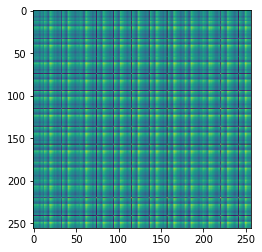

In [18]:
# View label
label = np.load('Processed/model_specific/labels_test/0.npy')
print('Model output', label.shape)
print(label)

# View RNN input
rnn_input = np.load('Processed/model_specific/X_rnn_test/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('Processed/model_specific/X_cnn_test/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

In [38]:
%cd DL_ECG_Classification

/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification


### 3.1 1D models

In [95]:
## RNN
!python3 rnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
Training loss: 0.6719
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 2
Training loss: 0.5585
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 3
Training loss: 0.4063
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 4
Training loss: 0.3203
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 5
Training loss: 0.2667
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 6
Training loss: 0.2304
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 7
Training loss: 0.2042
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 8
Training loss: 0.1844
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 9
Training loss: 0.1692
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 10
Training loss: 0.1570
Valid specificity: 0.9991
Valid sensitivity: 0.4004
Training epoch 11
Training loss: 0.1470
Valid specificity: 0.9991
Valid s

In [96]:
## LSTM
!python3 lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
Training loss: 0.7111
Training epoch 2
Training loss: 0.6601
Training epoch 3
Training loss: 0.5119
Training epoch 4
Training loss: 0.4093
Training epoch 5
Training loss: 0.3403
Training epoch 6
Training loss: 0.2928
Training epoch 7
Training loss: 0.2583
Training epoch 8
Training loss: 0.2322
Training epoch 9
Training loss: 0.2117
Training epoch 10
Training loss: 0.1953
Training epoch 11
Training loss: 0.1819
Training epoch 12
Training loss: 0.1708
Training epoch 13
Training loss: 0.1614
Training epoch 14
Training loss: 0.1533
Training epoch 15
Training loss: 0.1462
Training epoch 16
Training loss: 0.1399
Training epoch 17
Training loss: 0.1344
Training epoch 18
Training loss: 0.1296
Training epoch 19
Training loss: 0.1252
Training epoch 20
Training loss: 0.1212
Training epoch 21
Training loss: 0.1176
Training epoch 22
Training loss: 0.1143
Traceback (most recent call last):
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/lstm.py",

In [134]:
## GRU
!python3 gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python3 gru_with_attention.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
Training loss: 0.6854
Training epoch 2
Training loss: 0.5359
Training epoch 3
Training loss: 0.3734
Training epoch 4
Training loss: 0.2922
Training epoch 5
Training loss: 0.2434
Training epoch 6
Training loss: 0.2106
Training epoch 7
Training loss: 0.1872
Training epoch 8
Training loss: 0.1695
Training epoch 9
Training loss: 0.1557
Training epoch 10
Training loss: 0.1445
Training epoch 11
Training loss: 0.1355
Training epoch 12
Training loss: 0.1279
Training epoch 13
Training loss: 0.1215
Training epoch 14
Training loss: 0.1160
Training epoch 15
Training loss: 0.1113
Training epoch 16
Training loss: 0.1071
Training epoch 17
Training loss: 0.1033
Training epoch 18
Training loss: 0.1000
Training epoch 19
Training loss: 0.0971
Training epoch 20
Training loss: 0.0944
Training epoch 21
Training loss: 0.0919
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive

### 3.2 2D models

In [98]:
## AlexNet
!python3 AlexNet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training loss: 0.6937
Training epoch 2
Training loss: 0.6933
Training epoch 3
Training loss: 0.6929
Training epoch 4
Training loss: 0.6926
Training epoch 5
Training loss: 0.6922
Tr

In [99]:
## VGGNet
!python3 vggnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
^C
Traceback (most recent call last):
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/vggnet.py", line 230, in <module>
    main()
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/vggnet.py", line 156, in main
    model = VGG16(n_classes)
  File "/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/vggnet.py", line 32, in __init__
    self.fc1 = nn.Linear(65536, 4096)
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py", line 103, in __init__
    self.reset_parameters()
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py", line 109, in reset_parameters
    init.kaiming_uniform_(self.weight, a=math.sqrt(5))
  File "/home/nepython/.local/lib/python3.10/site-packages/torch/nn/init.py", line 459, in kaiming_uniform_
    return tensor.uniform_(-bound, bound, generator=generator)
KeyboardInterrupt


In [92]:
## ResNet
!python3 resnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training loss: 0.6048
Valid specificity: 0.4002
Valid sensitivity: 0.5996
Training epoch 2
Training loss: 0.5217
Valid specificity: 0.5999
Valid sensitivity: 0.5996
Training epoch 

In [88]:
## CNN
!python3 cnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python cnn_gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python cnn_lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training loss: 0.6598
Training epoch 2
Training loss: 0.5934
Training epoch 3
Training loss: 0.4510
Training epoch 4
Training loss: 0.3534
Training epoch 5
Training loss: 0.2933
Tr

### 3.3 Fusion approaches

Fusion uses 1D and 2D models so let's shift it's best models to new folder Models.

In [156]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [163]:
!python early_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Namespace(signal_data='../Processed/model_specific/', image_data='../Processed/model_specific/', signal_model='gru', image_model='alexnet', epochs=100, batch_size=256, learning_rate=0.01, dropout=0, l2_decay=0, optimizer='adam', gpu_id=0, path_save_model='saved_models/', hidden_size=256, early_stop=True, patience=10)
True 0 NVIDIA GeForce RTX 4090
+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| fc_img.weight |  1048576   |
|  fc_img.bias  |    256     |
|   fc1.weight  |   262144   |
|    fc1.bias   |    512     |
|   fc2.weight  |   131072   |
|    fc2.bias   |    256     |
|   out.weight  |    1280    |
|    out.bias   |     5      |
+---------------+------------+
Total Trainable Params: 1444101
Starting early fusion training at: 2025-05-30_02-38-27
Save models at: saved_models/EarlyFusionNet
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: C

In [168]:
!python late_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Namespace(signal_data='../Processed/model_specific/', image_data='../Processed/model_specific/', signal_model='gru', image_model='alexnet', epochs=100, batch_size=256, learning_rate=0.01, dropout=0.0, l2_decay=0, optimizer='adam', gpu_id=0, path_save_model='saved_models/', hidden_size=512, early_stop=True, patience=20)
True 0 NVIDIA GeForce RTX 4090
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| hidden.weight |    5120    |
|  hidden.bias  |    512     |
|   out.weight  |    2560    |
|    out.bias   |     5      |
+---------------+------------+
Total Trainable Params: 8197
Sta

In [172]:
!python joint_fusion.py -signal_data '../Processed/model_specific/' -image_data '../Processed/model_specific/' -signal_model=gru -image_model=alexnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

Namespace(signal_data='../Processed/model_specific/', image_data='../Processed/model_specific/', signal_model='gru', image_model='alexnet', epochs=100, batch_size=256, learning_rate=0.01, dropout=0, l2_decay=0.01, optimizer='adam', gpu_id=0, path_save_model='saved_models/', hidden_size=256, early_stop=True, patience=10)
True 0 NVIDIA GeForce RTX 4090
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
| sig_model.rnn.weight_ih_l0 |    2304    |
| sig_model.rnn.weight_hh_l0 |   196608   |
|  sig_model.rnn.bias_ih_l0  |    768     |
|  sig_model.rnn.bias_hh_l0  |    768     |
| sig_model.rnn.weight_ih_l1 |   196608   |
| sig_model.rnn.weight_hh_l1 |   196608   |
|  sig_model.rnn.bias_ih_l1  |    768     |
|  sig_model.rnn.bias_hh_l1  |    768     |
| img_model.conv2d_1.weight  |    8712    |
|  img_model.conv2d_1.bias   |     8      |
| img_model.conv2d_2.weight  |    3200    |
|  img_model.conv2d_2.bias   | 

## Evaluation

First, move best models to a separate directory

In [20]:
%cd DL_ECG_Classification/

/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification


In [173]:
%%bash
#!/bin/bash

# Define the source and destination directories
src_dir="saved_models"
dest_dir="Models"

# Create an associative array to store the largest file for each unique name
declare -A largest_files

# Loop through all files matching the pattern
for file in "$src_dir"/*_ep_*; do
  # Extract the base name (excluding ep_{n})
  base_name=$(basename "$file" | sed 's/_ep_[0-9]*//')
  
  # Check if this base name already has a file stored
  if [[ -z "${largest_files[$base_name]}" ]]; then
    largest_files[$base_name]="$file"
  else
    # Compare the current file with the stored file to find the one with the largest 'n'
    current_n=$(basename "$file" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    stored_n=$(basename "${largest_files[$base_name]}" | sed 's/.*_ep_\([0-9]*\).*/\1/')
    
    if (( current_n > stored_n )); then
      largest_files[$base_name]="$file"
    fi
  fi
done

# Copy the largest files to the new location and rename them
for base_name in "${!largest_files[@]}"; do
  cp "${largest_files[$base_name]}" "$dest_dir/$base_name"
done

In [27]:
!python eval_saved_models.py -gpu_id 0 \
    -model rnn \
    -path Models/RNN \
    -data ../validation/Processed/model_specific/

/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home

In [25]:
!python eval_saved_models.py -gpu_id 0 \
    -model gru \
    -path Models/GRU \
    -data ../validation/Processed/model_specific/

/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home

array([1., 0., 0., 0.])